In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_array, bmat
from scipy.sparse.linalg import splu, spsolve

from resistor_capacitor.src.array import Array
from resistor_capacitor.src.matrix import Matrix
from resistor_capacitor.src.equation import Equation
from resistor_capacitor.src.failure import Failure
from resistor_capacitor.breakdown import breakdown

In [2]:
length = 10
width = 2
seed = 1
val_cap = 1.0
time_step = 0.01

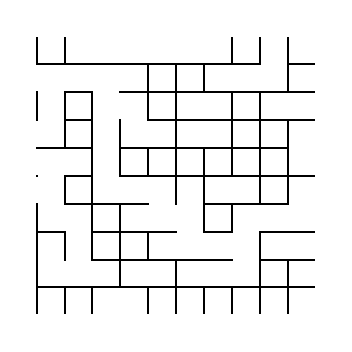

[2.28749635e-03 5.86623954e-02 2.54269339e-01 3.17119726e-01
 3.97192583e-01 4.25249871e-01 4.45388443e-01 6.07624902e-01
 8.35013161e-01 1.00029557e+00 1.15394083e+00 1.22648172e+00
 1.43800073e+00 1.57422453e+00 1.60276237e+00 1.60276237e+00
 1.68583211e+00 2.08225869e+00 2.21648200e+00 2.43783960e+00
 2.78504144e+00 2.90054373e+00 2.99071484e+00 3.07073057e+00
 3.07073057e+00 3.23399534e+00 3.23399534e+00 3.44284521e+00
 3.73082988e+00 4.03059976e+00 4.45469261e+00 5.71240480e+00
 5.71240480e+00 5.71240480e+00 6.04150513e+00 6.04150513e+00
 6.04150513e+00 6.04150513e+00 6.04150513e+00 6.31800667e+00
 6.84498967e+00 6.84498967e+00 7.12663777e+00 7.12663777e+00
 7.26319825e+00 7.34784028e+00 7.34784028e+00 7.91366791e+00
 7.91366791e+00 8.26465896e+00 8.81446953e+00 8.81446953e+00
 8.81850553e+00 8.81850553e+00 1.10070595e+01 1.10070595e+01
 1.10070595e+01 1.10070595e+01]


In [3]:
from analysis.rcc_src_tbc.draw import Draw


draw = Draw(*breakdown(length, width, seed,val_cap, time_step))
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(draw.failure.idxs_edge_broken, 0)
print(np.array(draw.failure.volts_ext))

---

In [4]:
array = Array(length=length, mode_analysis=True)
matrix = Matrix(matrix_init=None, array=array, val_cap=val_cap, time_step=time_step)
equation = Equation(array=array, matrix=matrix, save_volts_profile=True)
failure = Failure(array=array, matrix=matrix, equation=equation, width=width, seed=seed, save_volts_profile=True)

In [5]:
# CONSTANT EXTERNAL VOLTAGE (NO SCALING) EXPERIMENT
equation.volt_ext = 10.0
failure.idxs_edge_broken_nan = []

def break_edge_experimental(failure: Failure):
    failure._compute_volts_edge()
    stresses_edge_neg = failure.breaking_strengths - failure.volts_edge
    stresses_edge_neg[failure.idxs_edge_broken + failure.idxs_edge_leaf + failure.idxs_edge_island] = np.inf
    idx_edge_broken = failure._find_edge_broken_leaf_proof(stresses_edge_neg)

    if stresses_edge_neg[idx_edge_broken] <= 0:
        # print(0, end=", ") # max is overstressed
        failure._update_matrix(idx_edge_broken)
        failure.idxs_edge_broken.append(idx_edge_broken)
        failure.idxs_edge_broken_nan.append(idx_edge_broken)

    else:
        # print(1, end=", ") # all are understressed
        failure.idxs_edge_broken_nan.append(np.nan)

    failure._append_volts_edge_profile_dynamic()
    failure.volts_ext.append(float(failure.equation.volt_ext))

In [6]:
equation.solve_init()
break_edge_experimental(failure)

In [7]:
solve = equation.solve
solve_r = equation.solve_r_mmd
for _ in range(array.length - 1):
    solve_r()
    solve()
    break_edge_experimental(failure)

In [8]:
failure.degrees

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 3, 3,
       4, 3, 3, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3,
       4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [9]:
solve_r = equation.solve_r_amd
count = 0
while solve_r() and count < 1000:
    solve()
    break_edge_experimental(failure)

RecursionError: maximum recursion depth exceeded

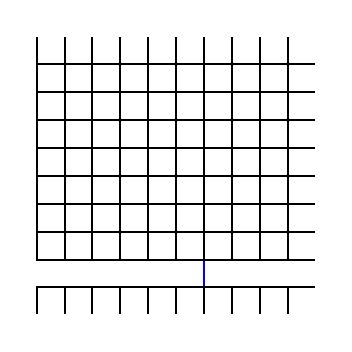

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


In [ ]:
from analysis.rcc_src_tbc.draw import Draw


draw = Draw(array, matrix, equation, failure)
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(draw.failure.idxs_edge_broken, 1)
print(np.array(draw.failure.volts_ext))

In [ ]:
print(failure.idxs_edge_broken_nan)

[166, 168, 169, 152, 154, 156, 158, 160, 162, 164]


In [ ]:
asdf

NameError: name 'asdf' is not defined

In [ ]:

# breakdown simulation
# 1st bond breaking [t=0]
solve = equation.solve_init
break_edge = failure.break_edge_init
solve()
break_edge()

# 2nd ~ (length)th bond breaking [t=1 ~ t=(length-1)]
solve = equation.solve
solve_r = equation.solve_r_mmd
break_edge = failure.break_edge
for _ in range(array.length - 1):
    solve_r()
    solve()
    break_edge()

# (length+1)th ~ (macroscopic failure) bond breaking [t=(length) ~ (total number of broken bonds-1)]
solve_r = equation.solve_r_amd
while solve_r():
    solve()
    break_edge()
